### Minimum Observations

In this simplest example, let's say you have a target consisting of a planetary system around a single cool, active dwarf. For this example, we'll use AU Mic. Let's say that, given an observing strategy of once per night, we want to know how many observations we would need to achieve a threshold uncertainty on the radial velocity semi-amplitude, K, of 10%. For AU Mic, with a K of 580 cm/s (Klein+ 2021), that means we want the minimum observations needed to reach an uncertainty of 58 cm/s. 

We'll start with the single planet case with a circular orbit and then generalize to include both AU Mic b and c. 

In [10]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from tinygp import kernels
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

from gaspery import calculate_fi, strategies, utils

1.22.3
1.7.3


In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

path = '/Users/chrislam/Desktop/gaspery/'

#### White noise case

We begin by declaring our target planet's orbital parameters. Our covariance matrix in the white noise regime is simply a diagonal matrix of the photon noise. In their modeling of AU Mic b, Klein+ 2021 estimated that noise to be 500 cm/s. 

In [5]:
### target parameters
p = 8.5 # orbital period, days
K = 580 # cm/s
T0 = 2360 # arbitrarily chosen fiducial central transit time, in BJD

### white/photon noise
sigma_wn_rv = 5 * 1e2 # [cm/s]

### choose arbitrary start time
start = 2352

We must also choose an observing cadence. The base case here is an observation once per day, for a cadence (time between observations) of 1 day.

In [6]:
c = 1 # observing cadence of once per day

Okay! The only thing we've left unconstrained is the number of observations. We can vary them, building an increasingly longer time series of observations, each time recalculating the covariance matrix, Fisher Information, and uncertainty on the RV semi-amplitude.

In [15]:
sigma_ks = []
for n_obs in tqdm(range(100)[4:]):
    
    # instantiate Star object in order to feed covariance matrix with white/correlated noise
    star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv)
    
    # populate list of parameters to feed into cov_matrix_jax()
    params = star.param_list()
    
    # instantiate Planets object in order to feed Fisher Info calculation machinery
    planet = calculate_fi.Planets(K = K, p = p, T0 = T0)
    
    # populate list of parameters to feed into clam_jax_fim()
    theta = planet.theta_list()
    
    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs = n_obs, cadence = 1, start = start, offs=[], dropout=0.)
    
    # build strategy aka time series of observations
    strat = strategy.gappy()
    
    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    sigma = calculate_fi.cov_matrix_jax(strat, params)
    sigma += 1e-6 

    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma, jnp.array(theta, dtype=float)
    
    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
    
    # invert FI matrix
    inv_fim = inv(fim)
    
    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    
    sigma_ks.append(sigma_k)
    

  0%|                                                                                                               | 0/96 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_42539/3368554183.py:26: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:32<00:00,  2.98it/s]


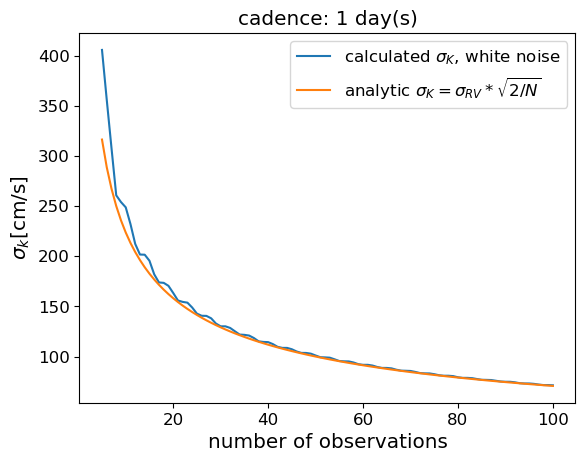

In [24]:
plt.plot(np.arange(len(sigma_ks))+5, sigma_ks, label='calculated $\sigma_K$, white noise')
plt.plot(np.arange(len(sigma_ks))+5, sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks))+5)), label='analytic $\sigma_K = \sigma_{RV}*\sqrt{2/N}$')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {c} day(s)")
plt.legend()
plt.show()

#### Correlated Noise Case

Finally, we declare the stellar noise parameters and populate the inputs for the covariance matrix and Fisher Information calculation functions.

In [7]:
### correlated noise parameters, from Klein+ 2021 for AU Mic
Prot = 4.86 # rotation period, days
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]

params = [Tau, eta, Prot, sigma_qp_rv]
theta = [K, p, T0]

In [27]:
sigma_ks_qp = []
for n_obs in tqdm(range(100)[4:]):
    
    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs, 1, start, offs=[], dropout=0.)
    
    # build strategy aka time series of observations
    strat = strategy.gappy()

    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    sigma_qp = calculate_fi.cov_matrix_jax(strat, sigma_wn_rv, params)
    sigma_qp += 1e-6 

    # populate arguments for Fisher Info calculator
    args_qp = np.array(strat), sigma_qp, jnp.array(theta, dtype=float)
    
    # calculate FI
    fim_qp = calculate_fi.clam_jax_fim(*args_qp).block_until_ready()
    
    # invert FI matrix
    inv_fim_qp = inv(fim_qp)
    
    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k_qp = np.sqrt(inv_fim_qp)[0][0]
    
    sigma_ks_qp.append(sigma_k_qp)
    

  0%|                                                                                                               | 0/96 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_42539/3762238225.py:24: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_qp = np.sqrt(inv_fim_qp)[0][0]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:31<00:00,  3.01it/s]


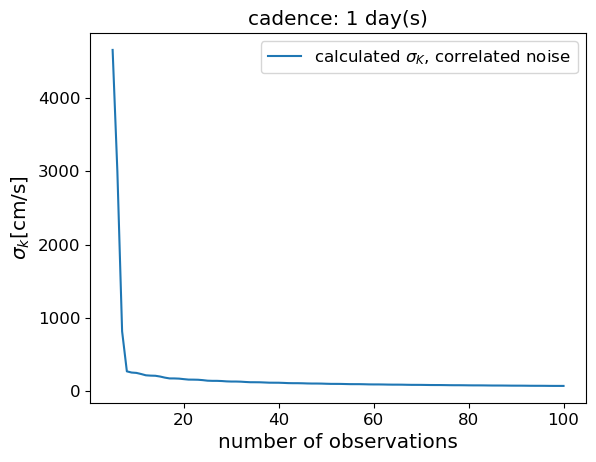

In [93]:
plt.plot(np.arange(len(sigma_ks))+5, sigma_ks_qp, label='calculated $\sigma_K$, correlated noise')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {c} day(s)")
plt.legend()
plt.show()

#### A Brief Aside to Combine Plots for the Paper

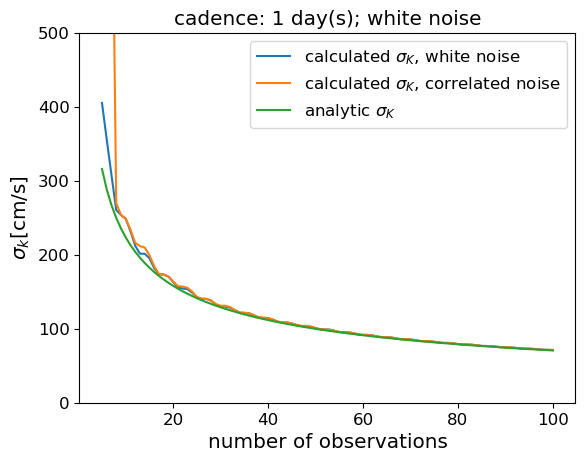

In [97]:
plt.plot(np.arange(len(sigma_ks))+5, sigma_ks, label='calculated $\sigma_K$, white noise')
plt.plot(np.arange(len(sigma_ks_qp))+5, sigma_ks_qp, label='calculated $\sigma_K$, correlated noise')
plt.plot(np.arange(len(sigma_ks))+5, sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks))+5)), label='analytic $\sigma_K$')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {c} day(s); white noise")
plt.legend()
plt.ylim([0, 500])
#plt.savefig(path + f"plots/au-mic/n_obs.png", format="png")
plt.show()

#### Visualize what a good strategy is sampling in phase space

The plot above is all well and good for confirming our hunch that more observations means better K estimates, but it doesn't really give us great intuition on **why** more observations is good. To get at this, let's phase fold the signal and plot the best strategy (ie. N = 99 observations) over it, to see the phase coverage. At the most basic level, the better the phase coverage, the better we have a handle on the RV semi-major amplitude.

We phase fold on the orbital period of the planet. First, let's phase fold the time support. Here, we'll show 200 days out from our arbitrary start date.

In [46]:
start = 2352 # BJD
end = 2552 # BJD
t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24) # support
t_phase_folded = t % p # phase fold support

Now, let's phase fold the planet signal.

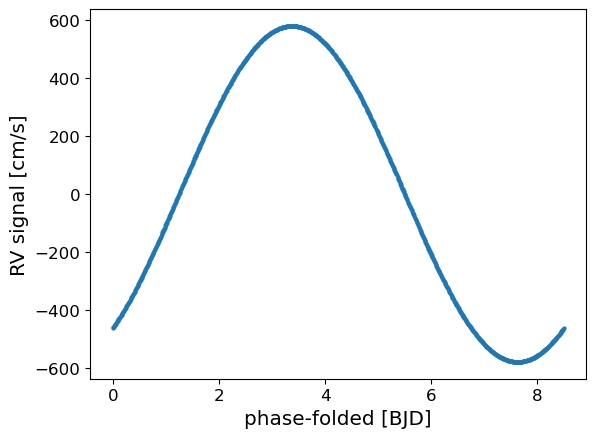

In [82]:
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, K, p, T0))

plt.scatter(t % p, y_phase_folded, s=4)
plt.ylabel('RV signal [cm/s]')
plt.xlabel('phase-folded [BJD]')
plt.show()

Then, let's phase fold the stellar signal and add it to the planet signal to get out the observed signal. We will use celerite2 (https://celerite2.readthedocs.io/en/latest/) to create a quasi-periodic Gaussian Process kernel and draw one (1) sample that we phase-fold, in order to illustrate the observational sampling over a realistic signal. 

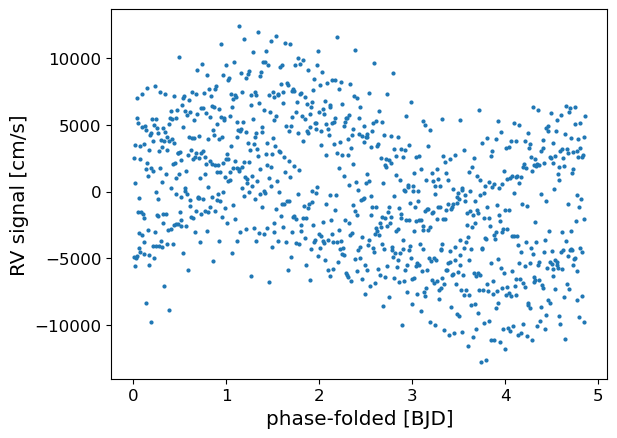

In [76]:
import celerite2
from celerite2 import terms

# quasiperiodic term
kernel = terms.SHOTerm(sigma=sigma_qp_rv, rho=Prot, tau=Tau)

# set up GP
gp = celerite2.GaussianProcess(kernel, mean=0.)

# compute GP
gp.compute(t, yerr=sigma_wn_rv)

# just take one sample to phase-fold for visualization purposes
sample = gp.sample(size=1)

# plot
plt.scatter(t % Prot, sample, s=4)
plt.ylabel('RV signal [cm/s]')
plt.xlabel('phase-folded [BJD]')
plt.show()

But hold on! Notice the vague suggestion of structure in the plot above. This structure shakes out because we phase fold by the rotation period, on which the correlated noise model depends -- however, we want the **planet** signal. 

When we phase fold on the orbital period, we get a lot less information.

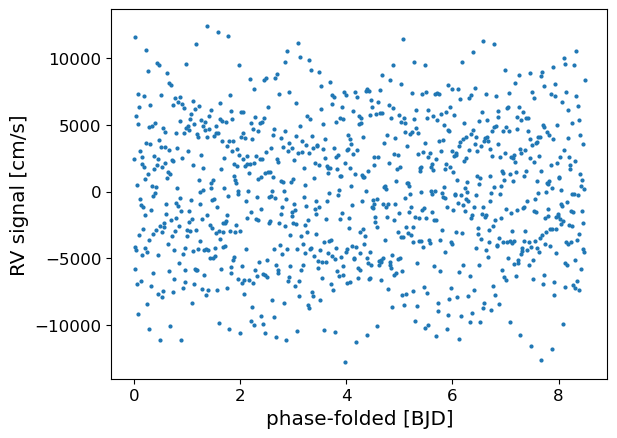

In [77]:
# plot
plt.scatter(t % p, sample, s=4)
plt.ylabel('RV signal [cm/s]')
plt.xlabel('phase-folded [BJD]')
plt.show()

Let's plot the phase folded planet plus stellar signal along with a dotted red line for every observation timestamp in the best (N = 99 observations) strategy. 

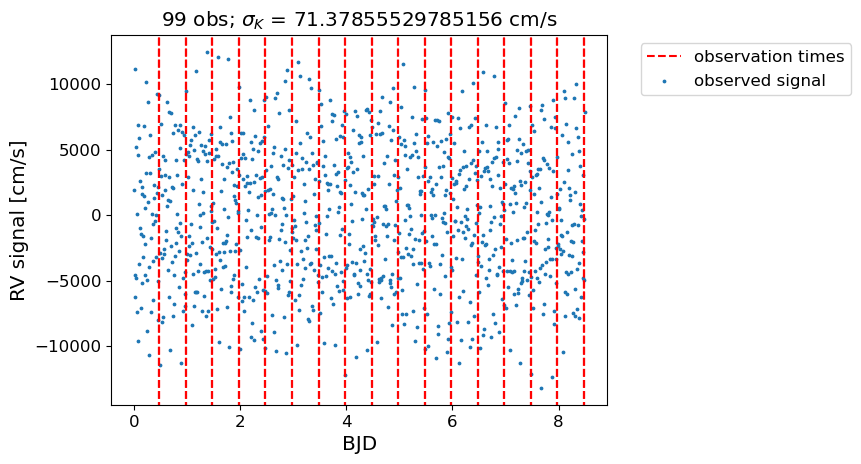

In [96]:
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat:
    plt.axvline(i % p, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r', alpha=0.5)
    
plt.scatter(t % p, sample + y_phase_folded, label='observed signal', s=3)
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV signal [cm/s]')
plt.title(f'{n_obs} obs; ' + r'${\sigma}_K$' + f' = {sigma_k_qp} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Multi-planet case